### Problem Description

## Task: Pricing Policy Recommendation

* **Task 1**: Should the company sell its software for $39$ or $59$?
    * Decision criterion: No cost information, focus on revenue (in particular), average revenue from any one person under two pricing policy. 
    
* **Task 2**: The VP of Product is interested in having a holistic view into **user behavior**, especially
focusing on actionable insights that might increase conversion rate. What are your main
findings looking at the data?

* **Task 3**: The VP of Product feels that the test has been running for too long and he should
have been able to get statistically significant results in a shorter time. Do you agree with
her intuition? After how many days you would have stopped the test? Please, explain
why.

### Findings and Recommendations
*
*

### Structure of the Notebook

* Exploratory Analysis and Visualization of the Data
    * Data type, missing value, summary statistics
    * Distribution of each variable and visualization
    * Correlation among variables
    
* Main Tasks
    * A/B testing
    * Actionable insights

Import Data

In [180]:
import pandas as pd
import numpy as np
from scipy import stats
import pandas_profiling
import matplotlib.pyplot as plt

In [2]:
test_df = pd.read_csv('test_results.csv')
user_df = pd.read_csv('user_table.csv')

In [104]:
test_df.columns

Index(['user_id', 'timestamp', 'source', 'device', 'operative_system', 'test',
       'price', 'converted', 'source_main_category', 'revenue'],
      dtype='object')

### Exploratory Analysis
* Distribution (summary statistics for each variable)
* Correlation

In [44]:
profile_test = pandas_profiling.ProfileReport(test_df)
profile_test

Number of variables,10
Number of observations,316800
Total Missing (%),0.0%
Total size in memory,24.2 MiB
Average record size in memory,80.0 B
Numeric,1
Categorical,5
Boolean,2
Date,0
Text (Unique),0
Rejected,2


In [45]:
profile_user = pandas_profiling.ProfileReport(user_df)
profile_user

Number of variables,5
Number of observations,275616
Total Missing (%),0.0%
Total size in memory,10.5 MiB
Average record size in memory,40.0 B
Numeric,3
Categorical,1
Boolean,0
Date,0
Text (Unique),0
Rejected,1


In [3]:
test_df['source'].unique()

array(['ads_facebook', 'seo-google', 'ads-bing', 'direct_traffic',
       'ads-google', 'seo_facebook', 'friend_referral', 'ads_other',
       'ads-yahoo', 'seo-yahoo', 'seo-bing', 'seo-other'], dtype=object)

In [4]:
conditions = [
    test_df.apply(lambda x: x['source'] in ['ads_facebook','ads-google','ads-yahoo','ads-bing','ads_other'],axis=1),
    test_df.apply(lambda x: x['source'] in ['seo-google','seo_facebook','seo-yahoo','seo-bing','seo-other'],axis=1),
    test_df.apply(lambda x: x['source'] in ['friend_referral'],axis=1),
    test_df.apply(lambda x: x['source'] in ['direct_traffic'],axis=1)
]
choices = ['ads', 'seo', 'fr', 'dt']
test_df['source_main_category'] = np.select(conditions, choices)

In [5]:
test_df['revenue'] = test_df['price']*test_df['converted']

In [176]:
test_df['device'] = test_df['device'].map({'web':0,'mobile':1})

In [177]:
test_df.head()

,user_id,timestamp,source,device,operative_system,test,price,converted,source_main_category,revenue
0,604839,2015-05-08 03:38:34,ads_facebook,1,iOS,0,39,0,ads,0
1,624057,2015-05-10 21:08:46,seo-google,1,android,0,39,0,seo,0
2,317970,2015-04-04 15:01:23,ads-bing,1,android,0,39,0,ads,0
3,685636,2015-05-07 07:26:01,direct_traffic,1,iOS,1,59,0,dt,0
4,820854,2015-05-24 11:04:40,ads_facebook,0,mac,0,39,0,ads,0


In [7]:
user_df.head()

,user_id,city,country,lat,long
0,510335,Peabody,USA,42.53,-70.97
1,89568,Reno,USA,39.54,-119.82
2,434134,Rialto,USA,34.11,-117.39
3,289769,Carson City,USA,39.15,-119.74
4,939586,Chicago,USA,41.84,-87.68


Story of the data: a user_id at a city from one country (lat, long), at certain time, via a source, a device, and an operation system, has seen a price (test and price contains equivalent information), and whether they bought it or not.

**Assumption**

The two populations have the same distribution in terms of features. (need to check this at least for marginal distribution).

In [8]:
test_df.shape,user_df.shape
#1. The are different, why?

((316800, 10), (275616, 5))

In [9]:
len(test_df['user_id'].unique())

316800

### Task 1: Pricing Suggestion

* Decision criterion: No cost information, focus on revenue (in particular), average revenue from any one person under two pricing policy. 

* Defining the problem: two pricing policies define two regimes, under each regime, each the revenue from one person as a random variable $\{Y_{1i}\}_{i=1}^{n_1}\in\{0,39\}$ with population success probability $p_1$, and $\{Y_{2i}\}_{i=1}^{n_2}\in\{0,59\}$, with population success probability $p_2$. ($p_1,p_2$ are conversion rates)

* Want to design a test to see if the population means of these two are the same or not. $\mu_1=39p_1,\mu_2=59p_2$.

The hypotheses are 

$$H_0:\mu_1<\mu_2\text{ v.s }H_1:\mu_1\ge\mu_2.$$

We should use a one-sided t test

$$t=\frac{\widehat\mu_1-\widehat\mu_2}{\sqrt{\frac{s_1^2}{n_1}+\frac{s_2^2}{n_2}}},$$

and reject $H_0$ if $t$ is large and positive.

In [10]:
class Solution:
    def __init__(self,y1,y2):
        self.y1 = y1
        self.y2 = y2
        self.n1 = len(self.y1)
        self.n2 = len(self.y2)
        self.df = self.n1 + self.n2 - 2 
        
    def t_test(self):
        
        mu1_hat, mu2_hat = self.y1.mean(), self.y2.mean()
        s1_sq_hat,s2_sq_hat = sum((self.y1-mu1_hat)**2)/(self.n1-1), sum((self.y2-mu2_hat)**2)/(self.n2-1)
        t = (mu1_hat-mu2_hat)/np.sqrt(s1_sq_hat/self.n1+s2_sq_hat/self.n2)
        
        return t
        
    def p_value(self, t, side = 'two_sided'):
        
        if side == 'two_sided':
            p = 2*(1-scipy.stats.t.cdf(abs(t), df = self.df))
        elif side == 'left':
            p = scipy.stats.t.cdf(t, df = self.df)
        else:
            p = 1-scipy.stats.t.cdf(t, df = self.df)
        
        return p

In [25]:
test_df_test = test_df.loc[test_df['test']==1]
test_df_control = test_df.loc[test_df['test']==0]
y1 = test_df_control['revenue']
y2 = test_df_test['revenue']

sol = Solution(y1,y2)
print('t test is {:0.4f}'.format(sol.t_test()), 'with p value {:0.4f}'.format(sol.p_value(sol.t_test(),side = 'right')))  
#, sol.p_value(sol.t_test(),side = 'right')

t test is -5.6572 with p value 1.0000


Conclusion: Do not reject the null hypothesis, we may increase the price ! Let us calculate the expected revenue under two prices for the whole population.

In [ ]:
#If the price was 39 for both samples

#If the price was 59 for both samples

### Multiple Hypotheses Testing

Given $\{X_{ki}\}_{i=1}^{n_k}$ from $F_k,k=1,2$, with means $\mu_k$ and variances $\sigma_k^2$. We consider the following multiple hypotheses:

\begin{align*}
&H_{10}:\mu_1=\mu_2\text{ vs. }H_{11}:\mu_1\ne\mu_2\\
&H_{20}:\sigma_1^2=\sigma_2^2\text{ vs. }H_{21}:\sigma_1^2\ne\sigma_2^2
\end{align*}

Let $\mathcal{D}=(\{X_{1i}\}_{i=1}^{n_1},\{X_{2i}\}_{i=1}^{n_2})$, and suppose we constructed two test statistics $T_j=T_j(\mathcal{D}),j=1,2$, with (deterministic) rejection regions $R_j$. Then we can define

\begin{align*}
p_j\left(R_j,T_j(\cdot),F_1,F_2,(H_{j0},H_{j1})\right)=P(T_j\in R_j),
\end{align*}

where $(H_{j0},H_{j1})$ signifies that this probability depends on whether $H_{j0}$ or $H_{j1}$ is true, and $T_j(\cdot)$ represents the way the test statistic $T_j$ is composed. We can now write 

\begin{align*}
p_{j0}\left(R_j,T_j(\cdot),F_1,F_2,H_{j0}\right)=P(T_j\in R_j|H_{j0}),\\
p_{j1}\left(R_j,T_j(\cdot),F_1,F_2,H_{j1}\right)=P(T_j\in R_j|H_{j1}),
\end{align*}

and by writing $H_{j0}$ or $H_{j1}$ behind $|$, there is no meaning of conditional distribution at all. They just mean that one dimension in $p_j(\cdot)$ is now fixed.

By construction, $P(T_j\in R_j|H_{j0})=\alpha$, $j=1,2$. Now define

\begin{align*}
p\Big(R_1,R_2,T_1(\cdot),T_2(\cdot),F_1,F_2,(H_{10},H_{11}),(H_{20},H_{21})\Big)=P(T_1\in R_1\text{ or }T_2\in R_2),
\end{align*}

where $(H_{10},H_{11}),(H_{20},H_{21})$ signifies its dependence on the actual regime of the two hypotheses (In each parenthesis, only one value can be chosen).

Given this, we are concerned about the following probability

\begin{align*}
P(T_1\in R_1\text{ or }T_2\in R_2|H_{10},H_{20})&=p\Big(R_1,R_2,T_1(\cdot),T_2(\cdot),F_1,F_2,H_{10},H_{20}\Big)\\
&\le P(T_1\in R_1|H_{10})+P(T_2\in R_2|H_{20})
\end{align*}

In words, this is the probability of rejecting at least one null hypothesis when each hypothesis is actually under its null regime. It is named as family wise error rate (FWER). We are interested in the behavior of $P(T_1\in R_1\text{ or }T_2\in R_2|H_{10},H_{20})$ and $P(T_1\in R_1|H_{10})+P(T_2\in R_2|H_{20})$ is just an estimate. 

In general, if we have $J$ different hypothesis, then

\begin{align*}
P\left(\cup_{j=1}^JT_j\in R_j|H_{j0},j=1,\cdots,J\right)\le\sum_{j=1}^JP(T_j\in R_j|H_{j0})=J\alpha,
\end{align*}

where the inequality is called Bonferroni inequality
, and $\alpha$ is originally set to be $0.05$. To control for the LHS quantity, we let $\alpha_0=\frac{\alpha}{J}$, and obtain

\begin{align*}
P\left(\cup_{j=1}^JT_j\in R_j|H_{j0},j=1,\cdots,J\right)\le\alpha.
\end{align*}

The cost we need to pay for this is the sacrificed power for each individual test. This is because, we know the LHS is less than $\alpha$. However, its actual value can be much less than $\alpha$, say $\alpha/2$. Then we are having a too good value for the FWER at the cost of controlling for a too small Type I error rate for each individual hypothesis.  

Alternatively, if we want to maintain the power, then we need to increase the sample size (i.e. to run the A/B test for a longer time).

**Question**: what can we do if we think that Bonferroni correction is too conservative?

**Answer 1**:

Another suggestion for improvement in power is to replace $\frac{\alpha}{J}$ with $1-(1-\alpha)^{\frac{1}{J}}$, where we have 

\begin{align*}
1-(1-\alpha)^{\frac{1}{J}}\ge\frac{\alpha}{J},
\end{align*}

and thus we are relaxing the family-wise error rate to some extent. Then we obtain

\begin{align*}
P\left(\cup_{j=1}^JT_j\in R_j|H_{j0},j=1,\cdots,J\right)\le J\left[1-(1-\alpha)^{\frac{1}{J}}\right]\ge\alpha.
\end{align*}

Doing some numerical computation reveals that this can still be a little conservative. Let $\alpha=0.05$, then

\begin{align*}
J\left[1-(1-\alpha)^{\frac{1}{J}}\right]=\left\{\begin{array}{cc}
0.0506&J=2\\
0.0508&J=3\\
0.0509&J=4\\
\end{array}\right.
\end{align*}

As a matter of fact, 

\begin{align*}
\lim_{J\to\infty}J[1-(1-\alpha)^{\frac{1}{J}}]=\lim_{x\downarrow 0}\frac{1-(1-\alpha)^x}{x}=-\log(1-\alpha)>\alpha.
\end{align*}

When $\alpha=0.05$, $-\log(1-\alpha)\approx0.05129$


**Answer 2**: we can use Holm's method, or Hochberg’s procedure (which uses Simes inequality instead of Bonferroni' inequality). Both of these utilizes order p values from multiple test statistics. They are more powerful than the Bonferroni correction.

**This is exactly like that we do bad thing one time, the probability of being caught was 0.05, what about the probability of being caught at least one once if we do it 100 times?**

### FDR

The idea is that when testing many hypotheses, we might be fine allowing a few false rejections, or false discoveries, as long as the majority of rejections are correct.

In the multiple hypothesis testing problem, instead of FWER, we can look for the false discovery rate (FDR). It is defined as the expected value of the ratio between  #FP and #Rejections. Both of these quantities are random variables, and we can calculate them in a simulation. Formally, let the true regime vector be $H=(H_1,H_2,\cdots,H_J)$, where $H_j$ can take regime $H_{j0}$ or $H_{j1}$. Then

\begin{align*}
FDR=E\left[\frac{\sum_{j=1}^J1(T_j\in R_j,H_{j0}\text{ is True})}{\sum_{j=1}^J1(T_j\in R_j)}\right],
\end{align*}

where $1(\cdot)$ is the indicator function. $1(T_j\in R_j,H_{j0}\text{ is True})$ is $1$ only when we both reject the $H_{j0}$ and we know that $H_{j0}$ is the true regime. If in one repetition of the simulation, the denominator is 0, then the ratio is set to be 0. 

To fully write out the dependence of $FDR$, we have
\begin{align*}
FDR=FDR\left(n_1,n_2,T_1(\cdot),T_2(\cdot),R,H,F\right)
\end{align*}

where $R=(R_1,\cdots,R_J)$ and the significance level $\alpha$ is embedded in the rejection region $R_j$. $F=(F_1,F_2)$ if we assume that there are two random samples only.

When all null hypotheses are actually true, i.e. $H=(H_{10},H_{20},\cdots,H_{J0})$, the FDR is equivalent to the FWER. If, however, the number of true null hypotheses is less than the number of total hypotheses, the FDR is smaller than or equal to the FWER. Thus, methods that control FWER will also control the FDR. As a result, controlling the FDR is a less stringent condition than controlling the FWER, and consequently FDR procedures are more powerful.
Controlling the FDR was made popular by Benjamini and Hochberg (1995), who developed a simple step-up procedure performed on the ordered p-values of the tests.

### BH Procedure

Given $J$ pair of hypotheses, we have $T_j,j=1,\cdots,J$ test statistics, and $p_j,j=1,\cdots,J$ p values. Sort these p values to get $p_{(1)}\le p_{(2)}\le\cdots\le p_{(J)}$, and the null hypotheses are also shuffled accordingly and denoted as $H_{(j)0}$, $j=1,\cdots,J$. There is an implicit map which we can think of two rows like the following table:

\begin{align*}
&~ 1,~~~ 2,~~~ 3,~~ 4\notag\\
&(3),(1),(4),(2)
\end{align*}

where the 1st column means that the p value associated with $H_{10}$ is the 3rd smallest.

Define the set $\mathcal{J}$ as

\begin{align*}
\mathcal{J}=\left\{j:j\le\max(k:p_{(k)})\le\frac{kq}{J}\right\},
\end{align*}

where $q$ is the level of FDR we want to control, usually set to be $0.1$ in practice. In words, we reject all null hypotheses with p value small enough. However, $k$ also appears on the RHS of the inequality to take into account that the order p values increase as $k$ increases.

Now we get a set of $j$ values, find the corresponding set in the second row of the above table, map them back to the first row and reject all those null hypotheses.

See [Here](https://multithreaded.stitchfix.com/blog/2015/10/15/multiple-hypothesis-testing/) for a good explanation and interactive illustration.

#### Focusing on Conversion Rate

In [181]:
y1 = test_df_control['converted']
y2 = test_df_test['converted']
y1.mean(), y2.mean()
sol = Solution(y1,y2)
print('t test is {:0.4f}'.format(sol.t_test()), 'with p value {:0.4f}'.format(sol.p_value(sol.t_test(),side = 'right')))  

t test is 9.0860 with p value 0.0000


In [182]:
#Using package to calculate the statistics
stats.ttest_ind(y1,y2,equal_var=False)

Ttest_indResult(statistic=9.08604644689466, pvalue=1.0339496325938204e-19)

In [40]:
source_category = ['ads','seo','fr','dt']
test_source = [test_df_ads,test_df_seo,test_df_fr,test_df_dt]
mu1_hat, mu2_hat, t, p = [],[],[],[]

for i in range(len(source_category)):
    data = test_source[i]
    control = data.loc[data['test']==0]
    test = data.loc[data['test']==1]

    y1,y2 = control['converted'], test['converted']
    mu1_hat.append(y1.mean())
    mu2_hat.append(y2.mean())
    
    sol = Solution(y1,y2)
    t.append(sol.t_test())
    p.append(sol.p_value(sol.t_test(),side='right'))

result = pd.DataFrame({'Source':source_category,'Control':mu1_hat, 'Test':mu2_hat, 't-value':t, 'p-value':p})
result.set_index('Source')

,Control,Test,p-value,t-value
Source,,,,
ads,0.020185,0.015841,1.600930e-11,6.637406
seo,0.018128,0.013922,2.097725e-05,4.096735
fr,0.041721,0.033466,1.143807e-03,3.050485
dt,0.013545,0.010094,6.122141e-05,3.841434


Low price leads to a higher conversion rate for all customer segmentation !

**Task 2**: customer segmentation

Main features: 

* source: hypothesis, users from either direct link or search might be willing to pay more than users from ads or friends referral.

* country: users from different countries have different income and thus willingness to pay.

Source

In [26]:
test_df_ads = test_df[test_df['source_main_category'] == 'ads']
test_df_seo = test_df[test_df['source_main_category'] == 'seo']
test_df_fr = test_df[test_df['source_main_category'] == 'fr']
test_df_dt = test_df[test_df['source_main_category'] == 'dt']

In [39]:
source_category = ['ads','seo','fr','dt']
test_source = [test_df_ads,test_df_seo,test_df_fr,test_df_dt]
mu1_hat, mu2_hat, t, p = [],[],[],[]

for i in range(len(source_category)):
    data = test_source[i]
    control = data.loc[data['test']==0]
    test = data.loc[data['test']==1]

    y1,y2 = control['revenue'], test['revenue']
    mu1_hat.append(y1.mean())
    mu2_hat.append(y2.mean())
    
    sol = Solution(y1,y2)
    t.append(sol.t_test())
    p.append(sol.p_value(sol.t_test(),side='right'))

result = pd.DataFrame({'Source':source_category,'Control':mu1_hat, 'Test':mu2_hat, 't-value':t, 'p-value':p})
result.set_index('Source')

,Control,Test,p-value,t-value
Source,,,,
ads,0.787412,0.934298,0.999993,-4.349001
seo,0.707488,0.821413,0.984321,-2.152561
fr,1.628626,1.974471,0.993322,-2.474337
dt,0.529296,0.595518,0.923980,-1.432378


## Is the testing result reliable?

Placebo test, and feature balance check.

In [117]:
feature_balance = ['user_id','source', 'device', 'operative_system']

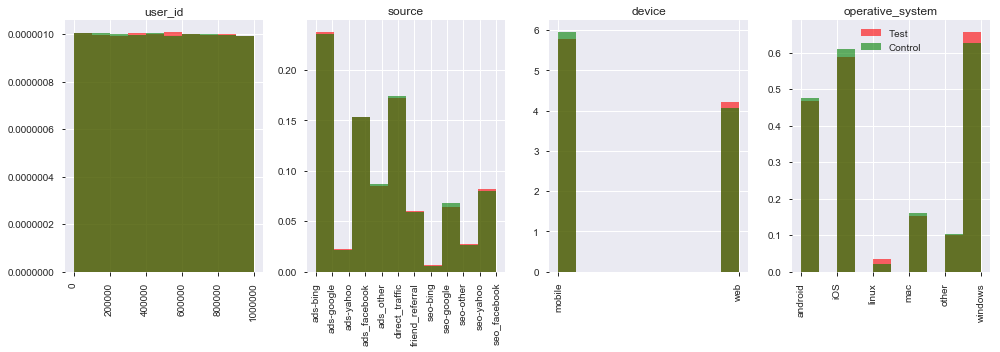

In [118]:
# Visualize characteristics for the Control and Test Classes
fig = plt.figure()
fig.set_size_inches(14, 5)

# Create 'for loop' to enerate the features and compare with histograms
for i,f in enumerate(feature_balance):
    i +=1
    ax = fig.add_subplot(1,4,i)
    ax.hist(test_df_test[f], label = 'Test', normed = True,alpha=0.6, color= 'red')
    ax.hist(test_df_control[f], label= 'Control', stacked = True, normed = True,alpha=0.6, color= 'green')
    plt.xticks(rotation='vertical')
    ax.set_title(f)

plt.tight_layout()
plt.legend(prop={'size': 10})
plt.show()

### Testing for Equality of Two Marginal Distributions

KS test for the Continuous Variable user_id

In [150]:
def chisquare_2samp(data1,data2):
    '''
    data1,data2 are pandas Series
    '''
    count_1,count_2 = np.array(data1.value_counts()), np.array(data2.value_counts())
    n1,n2 = sum(count_1), sum(count_2)
    chi2_test = sum((np.sqrt(n2/n1)*count_1-np.sqrt(n1/n2)*count_2)**2/(count_1+count_2))
    
    df = len(count_1)
    p_value = 1-scipy.stats.chi2.cdf(chi2_test,df=df)
    
    return chi2_test, p_value

In [175]:
test_same_dist = []

for i in feature_balance:
    if i == 'user_id':
        test_same_dist.append(list(scipy.stats.ks_2samp(test_df_test[i],test_df_control[i])))
    else:
        test_same_dist.append(list(chisquare_2samp(test_df_test[i],test_df_control[i])))

test_same_dist_df = pd.DataFrame({'feature':feature_balance, 
                                  'test statistic':[test_same_dist[i][0] for i in range(len(test_same_dist))], 
                                  'p value': [test_same_dist[i][1] for i in range(len(test_same_dist))]}).set_index('feature')
test_same_dist_df

,p value,test statistic
feature,,
user_id,0.952552,0.001910
source,0.030212,22.718632
device,0.000000,75.375018
operative_system,0.000000,299.441036


It seems that the experiment is well-designed !

Negative Control

In [179]:
test_df_test = test_df.loc[test_df['test']==1]
test_df_control = test_df.loc[test_df['test']==0]
y1 = test_df_control['device']
y2 = test_df_test['device']

sol = Solution(y1,y2)
print('t test is {:0.4f}'.format(sol.t_test()), 'with p value {:0.4f}'.format(sol.p_value(sol.t_test())))  
#, sol.p_value(sol.t_test(),side = 'right')

t test is 8.6692 with p value 0.0000


#### Focusing on Conversion Rate

Country

### Understanding Users
We need to understand the users since it is their action and choice that have generated the data.

Priority List

* Logistic Regression on Conversion.
    * Feature of interest and we can control: source channel (especially ads)
    * Approach I: focus on the subset of the ads and do one-hot encoding
    * Approach II: one-hot encoding everything and use the full sample

* FR can predict well but might not give actionable suggestions.

Approach I: subsample of ads sources

In [46]:
test_df_ads = test_df.loc[test_df['source_main_category']=='ads']

In [47]:
test_df_ads.head()

,user_id,timestamp,source,device,operative_system,test,price,converted,source_main_category,revenue
0,604839,2015-05-08 03:38:34,ads_facebook,mobile,iOS,0,39,0,ads,0
2,317970,2015-04-04 15:01:23,ads-bing,mobile,android,0,39,0,ads,0
4,820854,2015-05-24 11:04:40,ads_facebook,web,mac,0,39,0,ads,0
5,169971,2015-04-13 12:07:08,ads-google,mobile,iOS,0,39,0,ads,0
7,798371,2015-03-15 08:19:29,ads-bing,mobile,android,1,59,1,ads,59


In [51]:
test_df_ads_one_hot = pd.get_dummies(test_df_ads,columns=['device','operative_system','source'])

In [52]:
test_df_ads_one_hot.head()

,user_id,timestamp,test,price,converted,source_main_category,revenue,device_mobile,device_web,operative_system_android,operative_system_iOS,operative_system_linux,operative_system_mac,operative_system_other,operative_system_windows,source_ads-bing,source_ads-google,source_ads-yahoo,source_ads_facebook,source_ads_other
0,604839,2015-05-08 03:38:34,0,39,0,ads,0,1,0,0,1,0,0,0,0,0,0,0,1,0
2,317970,2015-04-04 15:01:23,0,39,0,ads,0,1,0,1,0,0,0,0,0,1,0,0,0,0
4,820854,2015-05-24 11:04:40,0,39,0,ads,0,0,1,0,0,0,1,0,0,0,0,0,1,0
5,169971,2015-04-13 12:07:08,0,39,0,ads,0,1,0,0,1,0,0,0,0,0,1,0,0,0
7,798371,2015-03-15 08:19:29,1,59,1,ads,59,1,0,1,0,0,0,0,0,1,0,0,0,0


features: test, device_dummies, os_dummies, ads_dummies

label: converted

In [60]:
import sklearn as sk
from sklearn import linear_model

In [56]:
test_df_ads_one_hot.columns

Index(['user_id', 'timestamp', 'test', 'price', 'converted',
       'source_main_category', 'revenue', 'device_mobile', 'device_web',
       'operative_system_android', 'operative_system_iOS',
       'operative_system_linux', 'operative_system_mac',
       'operative_system_other', 'operative_system_windows', 'source_ads-bing',
       'source_ads-google', 'source_ads-yahoo', 'source_ads_facebook',
       'source_ads_other'],
      dtype='object')

In [98]:
feature_set = ['test','device_mobile','operative_system_android', 'operative_system_iOS',
       'operative_system_linux', 'operative_system_mac', 'operative_system_windows',
       'operative_system_other',  'source_ads-bing',
       'source_ads-google', 'source_ads-yahoo', 'source_ads_facebook',
       'source_ads_other']

In [100]:
X = test_df_ads_one_hot[feature_set]
y = test_df_ads_one_hot['converted']
lr = sk.linear_model.LogisticRegression(class_weight ='balanced')
lr.fit(X,y)

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

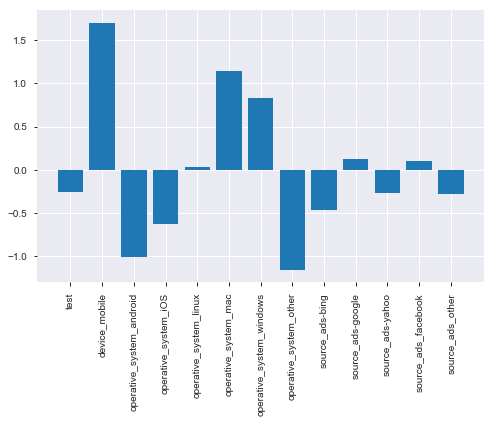

In [103]:
est = lr.coef_[0]
%matplotlib inline
plt.figure(figsize=(8,5))
x = range(len(feature_set))
plt.bar(x, est)
plt.xticks(x, feature_set, rotation='vertical')
plt.show()

Seem that facebook and google are doing good job in advertising !

### Summary